# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [37]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [38]:
# Import essential libraries
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as pilImage

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import sparse_categorical_crossentropy, binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

<b> Load the dataset. </b>

In [40]:
# Load and unzip the dataset 

# Unzip the dataset
with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall('GarbageData')

# Load the dataset
data_path = "GarbageData/Data"
data = os.listdir(data_path)
print("Data Path: "+data_path)
print("Content List: ", data)

Data Path: GarbageData/Data
Content List:  ['Paper', 'Food_Waste', 'Metal', 'Cardboard', 'Other', 'Glass', 'Plastic']


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [45]:
# Create a function to load the raw images

def load_image(filepath):
    img = pilImage.open(filepath)
    img = img.convert("RGB")
    return img
    

#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

In [47]:
def load_all_images(directory):
    images = []
    labels = []
    
    # Loop through each class folder
    for class_file in os.listdir(directory):
        class_path = os.path.join(directory, class_file)
        # Load each image in the class folder
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            img = load_image(img_path)
            images.append(img)
            labels.append(class_file)
                
    # Convert to NumPy arrays
    images = np.array(images)
    labels = np.array(labels) 
    return images, labels

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

Images Shape: (7625, 256, 256, 3)
Labels Shape : (7625,)


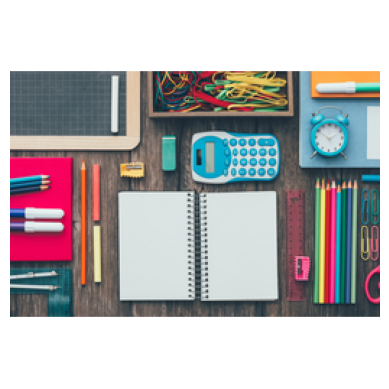

Label: Paper


In [49]:
# Get the images and their labels

# Load the data
images, labels = load_all_images(data_path)

# Verify the data
print("Images Shape:", images.shape)
print("Labels Shape :", labels.shape) 

# Verify the first image and its label
first_image = images[0]
first_label = labels[0]

# Display the image
plt.imshow(first_image)
plt.axis('off')
plt.show()

# Display the label
print("Label:", first_label)

Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

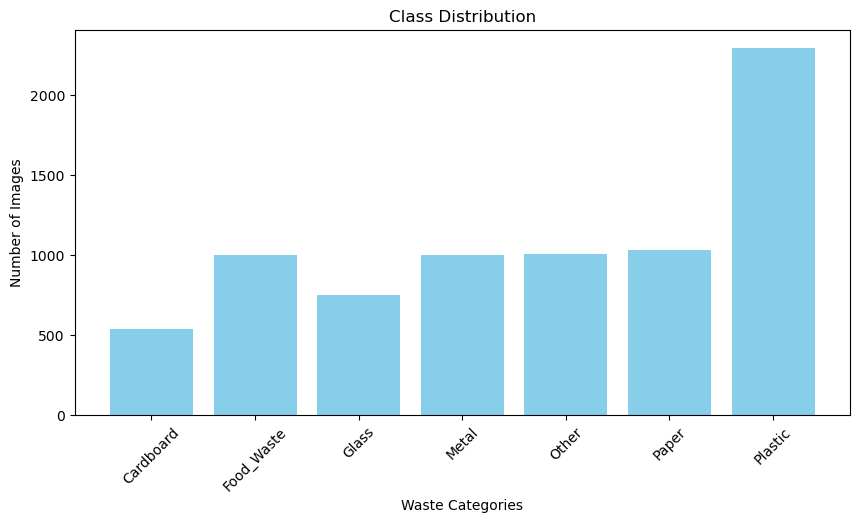

In [53]:
# Visualise Data Distribution

# Count images per label
label_names, label_counts = np.unique(labels, return_counts=True)
    
# Bar Plot
plt.figure(figsize=(10, 5))
plt.bar(label_names, label_counts, color='skyblue')
plt.xlabel('Waste Categories')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

First occurrence of 'Cardboard' is at index: 3030
First occurrence of 'Food_Waste' is at index: 1030
First occurrence of 'Glass' is at index: 4580
First occurrence of 'Metal' is at index: 2030
First occurrence of 'Other' is at index: 3570
First occurrence of 'Paper' is at index: 0
First occurrence of 'Plastic' is at index: 5330


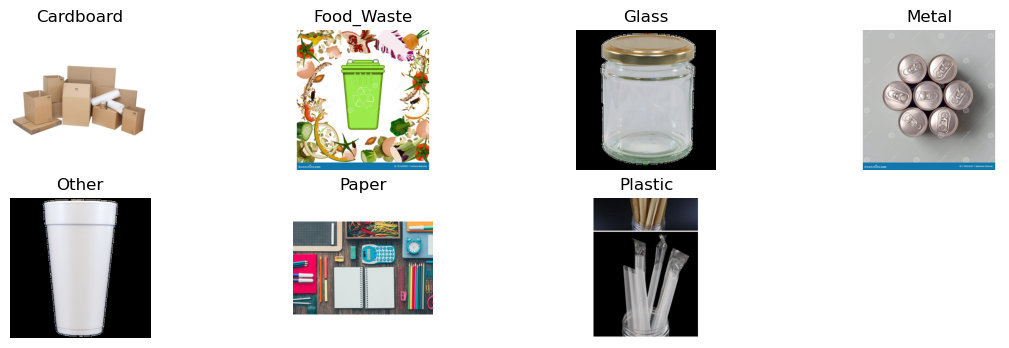

In [55]:
# Visualise Sample Images (across different labels)
    
# Let's display 1st sample image across each label
plt.figure(figsize=(14, 4))
for i, unique_label in enumerate(label_names):
    first_index = labels.tolist().index(unique_label)
    print(f"First occurrence of '{unique_label}' is at index: {first_index}")
    plt.subplot(2, 4, i+1)
    plt.imshow(images[first_index])
    plt.title(labels[first_index])
    plt.axis('off')
plt.show()

#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [57]:
# Find the smallest and largest image dimensions from the data set

# Initialize with the dimensions of the first image
first_height, first_width = images[0].shape[:2]
min_height = max_height = first_height
min_width = max_width = first_width

# Iterate through the rest of the images
for img in images[1:]:
    height, width = img.shape[:2]
    min_height = min(min_height, height)
    min_width = min(min_width, width)
    max_height = max(max_height, height)
    max_width = max(max_width, width)

print(f"Minimum Height: {min_height}")
print(f"Minimum Width: {min_width}")
print(f"Maximum Height: {max_height}")
print(f"Maximum Width: {max_width}")

Minimum Height: 256
Minimum Width: 256
Maximum Height: 256
Maximum Width: 256


In [58]:
# Resize the image dimensions
target_height, target_width = 224, 224

resized_images = np.array([
    tf.image.resize(img, [target_height, target_width]).numpy()
    for img in images
])

# Normalise the images
resized_images = np.array(resized_images, dtype='float32') / 255.0

# Verify the dimension of first resized image
print(resized_images[0].shape)   

(224, 224, 3)


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [62]:
# Encode the labels 
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

print("Encoded labels:", encoded_labels)
print("Classes:", label_encoder.classes_)

Encoded labels: [5 5 5 ... 6 6 6]
Classes: ['Cardboard' 'Food_Waste' 'Glass' 'Metal' 'Other' 'Paper' 'Plastic']


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [65]:
# Assign specified parts of the dataset to train and validation sets

X_train, X_val, y_train, y_val= train_test_split(resized_images, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(6100, 224, 224, 3) (1525, 224, 224, 3) (6100,) (1525,)


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [70]:
# Build and compile the model

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.4),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(label_names), activation='softmax')  
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,400,583 (169.37 MB)

 Trainable params: 44,400,135 (169.37 MB)

 Non-trainable params: 448 (1.75 KB)

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [73]:
# Callback to stop training if validation loss doesn't improve
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

# Training the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)
history.history

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 147s 764ms/step - accuracy: 0.2455 - loss: 25.6164 - val_accuracy: 0.1220 - val_loss: 12.9496
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.2958 - loss: 1.9073 - val_accuracy: 0.2551 - val_loss: 3.2162
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.3070 - loss: 1.8200 - val_accuracy: 0.3095 - val_loss: 3.1627
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.3098 - loss: 1.8596 - val_accuracy: 0.2570 - val_loss: 8.8663
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 191s 998ms/step - accuracy: 0.3136 - loss: 1.8157 - val_accuracy: 0.2957 - val_loss: 2.3617
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.3182 - loss: 1.7609 - val_accuracy: 0.2977 - val_loss: 2.6476
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 0.3212 - loss: 1.7879 - val_accuracy: 0.3364 - val_loss: 3.0013
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 329s 2s/step - accuracy: 0.3167 - loss: 1.7422 - 

{'accuracy': [0.26557376980781555,
  0.3055737614631653,
  0.3132786750793457,
  0.3122950792312622,
  0.3163934350013733,
  0.3163934350013733,
  0.31934425234794617,
  0.31803280115127563,
  0.32114753127098083,
  0.32229506969451904,
  0.33000001311302185,
  0.31704917550086975,
  0.3239344358444214,
  0.3227868974208832,
  0.32540982961654663,
  0.32885244488716125,
  0.33950820565223694,
  0.3591803312301636,
  0.36196720600128174,
  0.36770492792129517],
 'loss': [10.755455017089844,
  1.8780109882354736,
  1.807856559753418,
  1.833566665649414,
  1.7836198806762695,
  1.7721089124679565,
  1.7864267826080322,
  1.7356675863265991,
  1.7137517929077148,
  1.6935054063796997,
  1.6811912059783936,
  1.7469955682754517,
  1.7412476539611816,
  1.7192069292068481,
  1.6933660507202148,
  1.6531797647476196,
  1.6241741180419922,
  1.6189888715744019,
  1.5955924987792969,
  1.5835195779800415],
 'val_accuracy': [0.12196721136569977,
  0.25508198142051697,
  0.30950820446014404,
  0

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

In [76]:
# Evaluate on the Validation set
loss, accuracy = model.evaluate(X_val, y_val)

# Predict class probabilities
y_pred_probs = model.predict(X_val)

# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute evaluation metrics
precision = precision_score(y_val, y_pred, average='macro')  
f1 = f1_score(y_val, y_pred, average='macro')

# Print the results
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.3377 - loss: 1.8254
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step
Loss: 1.8037259578704834
Accuracy: 0.3442623019218445
Precision: 0.3635724759737105
F1 Score: 0.21625624551112835


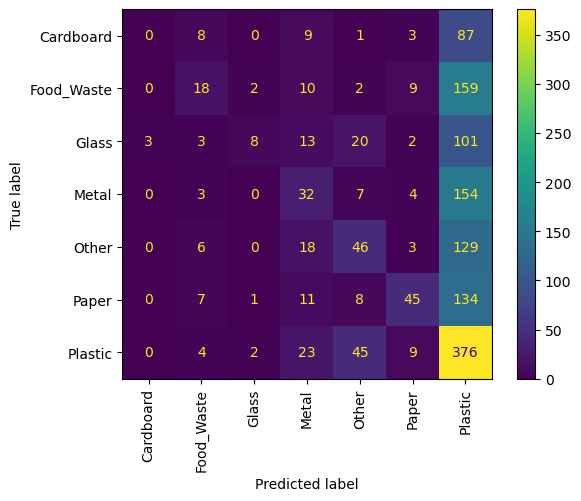

In [77]:
# Display confusion Matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(xticks_rotation='vertical')
plt.show()

### Test Different Configurations: 

In [79]:
# Define different configurations
configurations =[
    {'name':'Config 1', 'filters': 32, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'activation': 'relu', 'dropout_rate': 0.2, 'conv_layers' : 3},
    {'name':'Config 2', 'filters': 64, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'activation': 'relu', 'dropout_rate': 0.3, 'conv_layers' : 3},
    {'name':'Config 3', 'filters': 128, 'kernel_size': (3, 3), 'pool_size': (2, 2), 'activation': 'relu', 'dropout_rate': 0.4, 'conv_layers' : 3},
]

# Create a function to build the model
def create_model(config):
    model = Sequential()
    for i in range(config['conv_layers']):
        if i == 0:
            model.add(Conv2D(config['filters'], config['kernel_size'], activation=config['activation'], input_shape=(224, 224, 3)))
        else:
            model.add(Conv2D(config['filters'], config['kernel_size'], activation=config['activation']))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=config['pool_size']))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(config['dropout_rate']))
    model.add(Dense(len(set(encoded_labels)), activation='softmax'))
    return model    

In [80]:
# Training
epochs = 10
batch_size = 32
history_dict = {}
for config in configurations:
    model = create_model(config)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[early_stop])
    history_dict[config['name']] = history.history
    loss, accuracy = model.evaluate(X_val, y_val)
    y_pred_probs = model.predict(X_val)
    y_pred = np.argmax(y_pred_probs, axis=1)
    precision = precision_score(y_val, y_pred, average='macro')  
    f1 = f1_score(y_val, y_pred, average='macro')
    print(f"Loss: {loss}, Accuracy: {accuracy}")
    print(f"Precision: {precision}, F1 Score: {f1}")

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 105s 548ms/step - accuracy: 0.2745 - loss: 3.0265 - val_accuracy: 0.2269 - val_loss: 1.9778
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 102s 532ms/step - accuracy: 0.3277 - loss: 1.7429 - val_accuracy: 0.3036 - val_loss: 1.8308
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 103s 538ms/step - accuracy: 0.3954 - loss: 1.6075 - val_accuracy: 0.4039 - val_loss: 1.8002
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 104s 543ms/step - accuracy: 0.4468 - loss: 1.4157 - val_accuracy: 0.3980 - val_loss: 1.6106
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 103s 537ms/step - accuracy: 0.4958 - loss: 1.2940 - val_accuracy: 0.3980 - val_loss: 1.7427
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 101s 528ms/step - accuracy: 0.5199 - loss: 1.2187 - val_accuracy: 0.4590 - val_loss: 1.5772
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 101s 527ms/step - accuracy: 0.5609 - loss: 1.1192 - val_accuracy: 0.4839 - val_loss: 2.0668
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 102s 532ms/step - accuracy: 0.5880 -

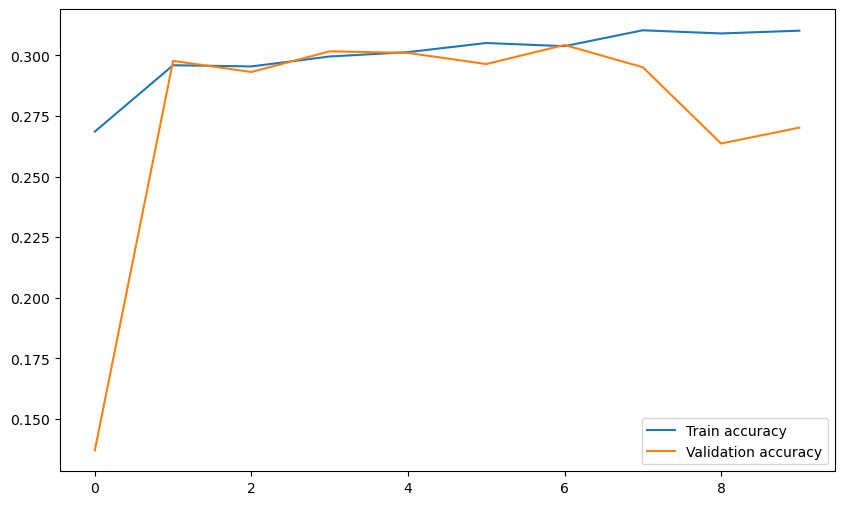

In [81]:
# Plot the Train Accuracy and Validation Accuracy
plt.figure(figsize=[10,6])
plt.plot(history.history["accuracy"], label = "Train accuracy")
plt.plot(history.history["val_accuracy"], label = "Validation accuracy")
plt.legend()
plt.show()

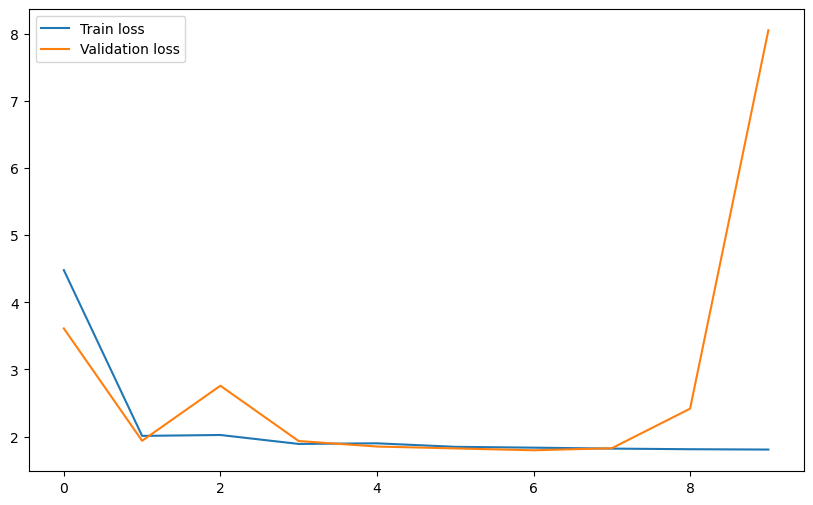

In [82]:
# Plot the Training loss and Validation Loss
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label = "Train loss")
plt.plot(history.history['val_loss'], label = "Validation loss")
plt.legend()
plt.show()

## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [86]:
# Define augmentation steps to augment images

# Create ImageDataGenerator with augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [89]:
# Resize images
X_resized = np.array([tf.image.resize(img, [128, 128]).numpy() for img in images])
y_encoded = encoded_labels

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weights = dict(enumerate(class_weights))

# Split data
X_train, X_val, y_train, y_val = train_test_split(X_resized, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

# Create generators
train_gen = datagen.flow(X_train, y_train, batch_size=32, subset='training')
val_gen = datagen.flow(X_val, y_val, batch_size=32, subset='validation')

# Define a simple CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax') 
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

(6100, 128, 128, 3) (1525, 128, 128, 3) (6100,) (1525,)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,393,223 (28.20 MB)

 Trainable params: 7,393,223 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

##### **4.1.2**

Train the model on the new augmented dataset.

In [131]:
# Train the model with class weights
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    class_weight=class_weights,
    callbacks=[early_stop]
)

# Evaluate the Augmented Model
loss, accuracy = model.evaluate(val_gen)
print(f"Accuracy: {accuracy}, Loss: {loss}")

Epoch 1/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.5458 - loss: 1.1213 - val_accuracy: 0.4623 - val_loss: 1.3886
Epoch 2/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.5499 - loss: 1.1235 - val_accuracy: 0.4852 - val_loss: 1.4184
Epoch 3/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step - accuracy: 0.5510 - loss: 1.1294 - val_accuracy: 0.4754 - val_loss: 1.4471
Epoch 4/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - accuracy: 0.5420 - loss: 1.1439 - val_accuracy: 0.4885 - val_loss: 1.4580
Epoch 5/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - accuracy: 0.5478 - loss: 1.1371 - val_accuracy: 0.5148 - val_loss: 1.3944
Epoch 6/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 14s 93ms/step - accuracy: 0.5547 - loss: 1.1062 - val_accuracy: 0.5115 - val_loss: 1.4218
Epoch 7/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - accuracy: 0.5657 - loss: 1.0857 - val_accuracy: 0.4754 - val_loss: 1.4314
Epoch 8/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 14s 93ms/step - accuracy: 0.5564 - loss: 1.0949 - 

## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results

### Findings About the Data
- The dataset consisted of images grouped into 7 categories: Cardboard, Food Waste, Glass, Metal, Paper, Plastic, and Other.
- Class imbalance was observed — certain categories like Plastic and Food Waste had more samples than others like Cardboard or Glass.
- Images varied in lighting, background, and angles, which made it a good test of model generalizability but also introduced noise.
- No sub-labeling was available within each category (e.g., all food items grouped under Food Waste), which slightly limited granularity in learning specific patterns within a class.

### Model Training Results
- A Convolutional Neural Network (CNN) was trained on the dataset using image augmentation (e.g., random flip, rotation, zoom) to improve generalization.
- Confusion matrix showed strong performance in identifying distinct categories like Glass and Plastic, while some confusion occurred between visually similar classes like Paper and Cardboard.
- Data augmentation played a key role in reducing overfitting and boosting performance on unseen data.

### Insights
- CNNs can be effectively used for real-time waste classification based on image input, contributing to automated waste sorting systems.
- The model performed best on well-defined classes with distinct textures or colors (e.g., Metal, Glass).
- Additional labeling or sub-categorization could improve classification accuracy by helping the model distinguish finer details.
- Deploying this system in smart bins or waste management facilities could significantly improve the efficiency of recycling and reduce manual labor.